In [188]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
from scipy import optimize

%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE/1.5, direction='out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE/1.5, direction='out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE/2)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
# Retreive all the data from the meta-data_epoch file
meta_data = ascii.read('../dataredred/J0600_meta-data_epoch.txt')

epoch_arr = np.array(meta_data["EPOCH"])

filters = np.array(meta_data["FILTER"]) # Filters of all the .fits images
airmass_arr = np.array(meta_data["AIRMASS"]) # Airmasses for all the .fits images

fits_name_arr = np.array(meta_data["IMAGE"]) # Name of the original .fits file
files_arr = np.array(meta_data["FILENAME"]) # Name of the data reduced files

N_files = len(epoch_arr) #nr of files
N_stars = len(ascii.read(files_arr[0])["STARNR"])-1 #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 1656
Number of stars = 20


In [3]:
# Make a mask for all the filters:
filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in filt:
        filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)
print (NimgINf)

fmask = {}
for f in filt:
    fmask[f] = filters == f

    
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars+1))
fluxerr_tmp = np.zeros((N_files,N_stars+1))

for i in range(N_files):
    file = files_arr[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = np.array(filecontent["FLUX"])
    fluxerr_tmp[i] = np.array(filecontent["FLUXERR"])

print (np.shape(flux_tmp))
print (np.shape(fluxerr_tmp))


# Make a dictionary where flux[filter] gives an array with all the data for that filter
# And do the same for epoch, airmass, fits_name and files
J0600_flux = {}
J0600_fluxerr = {}
flux = {}
fluxerr = {}

epoch = {}
airmass = {}
fits_name = {}
files = {}

for f in filt:
    J0600_flux[f] = flux_tmp[fmask[f]][:,0]
    J0600_fluxerr[f] = fluxerr_tmp[fmask[f]][:,0]
    flux[f] = flux_tmp[fmask[f]][:,1:]
    fluxerr[f] = fluxerr_tmp[fmask[f]][:,1:]
    
    epoch[f] = epoch_arr[fmask[f]]
    airmass[f] = airmass_arr[fmask[f]]
    fits_name[f] = fits_name_arr[fmask[f]]
    files[f] = files_arr[fmask[f]]


['gp', 'ip', 'rp']
{'gp': 743, 'ip': 601, 'rp': 312}
(1656, 21)
(1656, 21)


In [4]:
# Retreive the data from the meta-data_stars file
meta_data_stars = ascii.read("../dataredred/J0600_meta-data_stars.txt")

J0600_coords = [meta_data_stars[filt[0]+'_RA'][0],meta_data_stars[filt[0]+'_Dec'][0]]

original_starnr = {}
star_coords = {}
for f in filt:
    original_starnr[f] = np.array(meta_data_stars[f+"_star"][1:])
    
    RA = meta_data_stars[f+'_RA'][1:]
    Dec = meta_data_stars[f+'_Dec'][1:]
    star_coords[f] = np.array([RA,Dec]).transpose()

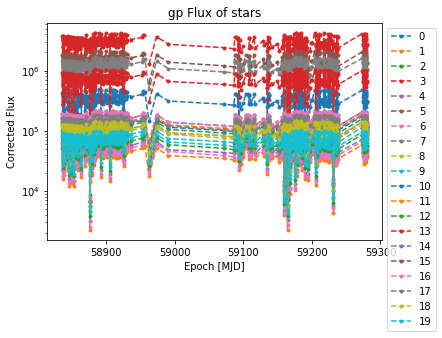

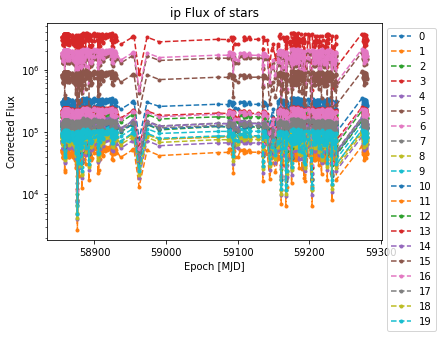

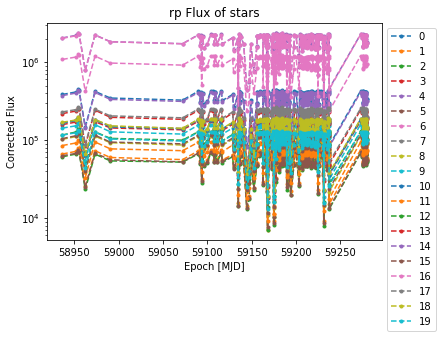

In [5]:
# Try the data
for f in filt:
    for s in range(N_stars):
        plt.plot(epoch[f],flux[f][:,s],linestyle='dashed',marker='.',label=s)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" Flux of stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()

# Extract magnitudes from Gaia DR2 (or EDR3?) & use for flux -> mag

In [6]:
# Extract the magnitudes from the stars in 400" radius around J0600
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Coords of J0600: 90.00316332976436 -31.007910088843165
coord = SkyCoord(ra=90.003163, dec=-31.007910, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(400, u.arcsec)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
r.pprint()


Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2891196718939580672 ... 0.00013201426578689563
1635721458409799680 Gaia DR2 2891196684579844864 ...   0.009094052279059428
1635721458409799680 Gaia DR2 2891196753298345472 ...   0.010658205399898254
1635721458409799680 Gaia DR2 2891196684579845376 ...   0.011317279008876314
1635721458409799680 Gaia DR2 2891196753297490304 ...   0.012358430209092582
1635721458409799680 Gaia DR2 2891196920800325760 ...   0.013193050363307734
1635721458409799680 Gaia DR2 2891196753299317632 ...   0

In [7]:
# To link the correct Gaia entries to our stars, select star with nearest coordinates
filt2 = ['gp','rp']

def find_stars(xobj_list, yobj_list, xlist, ylist, f):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    """
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=4)
    plt.scatter(xobj_list, yobj_list, c='red', s=2)
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title(f)
    plt.show()
    """
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

def distance(xobj,yobj, xlist,ylist):
    'find the distance between target & objects round it, returns list with distances in pixels'
    d = (xobj-xlist)**2 + (yobj-ylist)**2
    return np.sqrt(d)

In [8]:
# Making a mask for the gaia data to extract the data from the relevant stars
gaiamask = {}
for f in filt:
    stars_arg, d = find_stars(star_coords[f][:,0],star_coords[f][:,1],np.array(r['ra']),np.array(r['dec']),f)
    gaiamask[f] = stars_arg
    max_d = 1 #if distance is bigger than 1", it is to much
    if np.sum(d >= max_d) != 0:
        print ("Stars that are too distant")
        print (f, np.arange(N_stars)[d >= max_d])
    plt.show()

# Making a dictionary for the gaia magnitude of the selected stars
gaia_mag = {}
gaia_mag[filt[0]] = np.array(r['phot_g_mean_mag'][gaiamask[filt[0]]]) #gaia filter g, not gp
gaia_mag[filt[2]] = np.array(r['phot_rp_mean_mag'][gaiamask[filt[2]]])

In [9]:
# Extract the Gaia J0600 data
# Coords of J0600: 90.00316332976436 -31.007910088843165
d = distance(90.00316332976436, -31.007910088843165, r['ra'],r['dec'])

J0600_gaia = r[np.argmin(d)]

print (J0600_gaia['dec'])
print (J0600_gaia['astrometric_pseudo_colour'])

-31.00780455726246
1.467553481950413


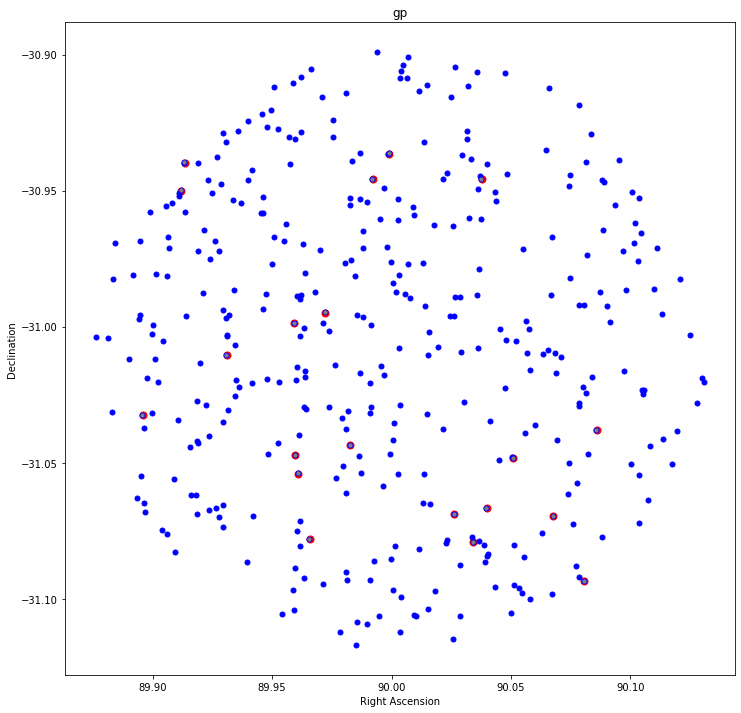

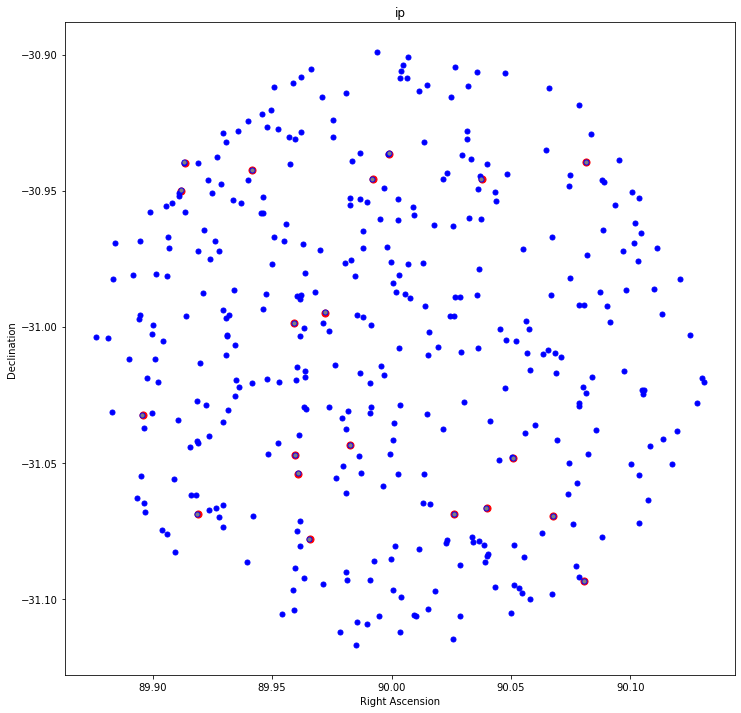

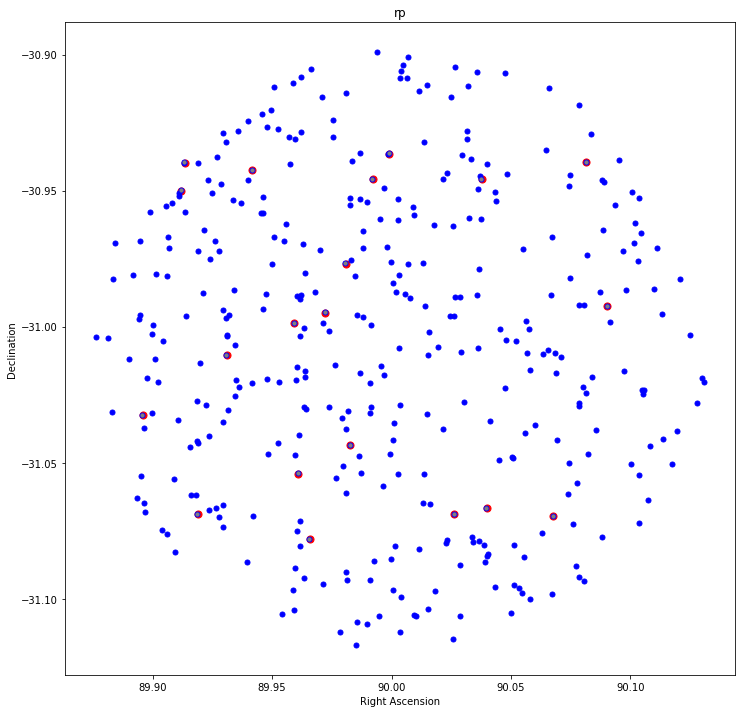

In [10]:
# Make a plot to check if the right stars are selected
for f in filt:
    plt.figure(figsize=(12,12))
    #plt.scatter(standards['RA'][0],standards['Dec'][0], c='r',s=15)
    plt.scatter(star_coords[f][:,0],star_coords[f][:,1], c='r',s=50)
    plt.scatter(r['ra'],r['dec'],c='b',s=25)
    plt.scatter(r['ra'][gaiamask[f]],r['dec'][gaiamask[f]],c='grey',s=10)
    plt.xlabel("Right Ascension")
    plt.ylabel("Declination")
    #plt.axis(xmin=89.90,xmax=89.94,ymin=-30.96,ymax=-30.92)
    #plt.axis(xmin=89.86,xmax=90.01,ymin=-31.02,ymax=-30.88)
    plt.title(f)
    plt.show()

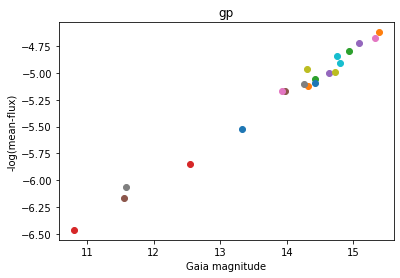

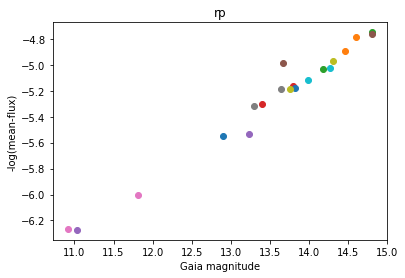

20


In [11]:
# Making a plot of the gaia magnitude on x-axis and -log(meanflux) on the y axis for selected stars
#  if all is well, this should result in a straight line.

for f in ['gp','rp']:
    for s in range(N_stars):
        nonNaN = np.isnan(flux[f][:,s])==False
        plt.scatter(gaia_mag[f][s],-1*np.log10(np.mean(flux[f][:,s][nonNaN])))
    plt.title(f)
    plt.xlabel("Gaia magnitude")
    plt.ylabel("-log(mean-flux)")
    plt.show()
print (len(gaia_mag['gp']))

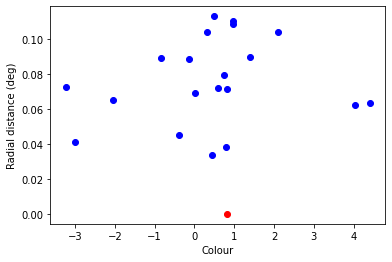

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


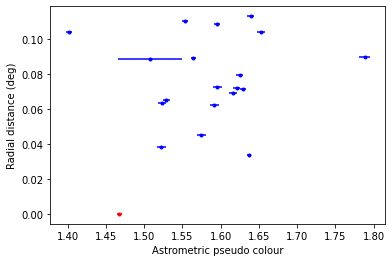

In [12]:
# Radial distance to J0600 plotted as function of colour
d_to_J0600 = distance(90.00316332976436, -31.007910088843165,r['ra'][gaiamask['rp']],r['dec'][gaiamask['rp']])

plt.scatter(gaia_mag['gp']-gaia_mag['rp'], d_to_J0600,c='b')
plt.scatter(J0600_gaia['phot_g_mean_mag']-J0600_gaia['phot_rp_mean_mag'],np.min(d),c='r')
plt.xlabel('Colour')
plt.ylabel('Radial distance (deg)')
plt.show()

plt.errorbar(r['astrometric_pseudo_colour'][gaiamask['rp']], d_to_J0600,\
             xerr = r['astrometric_pseudo_colour_error'][gaiamask['rp']],fmt='.', c='b')
plt.errorbar(J0600_gaia['astrometric_pseudo_colour'],np.min(d),\
             xerr=J0600_gaia['astrometric_pseudo_colour_error'],fmt='.',c='r')
plt.xlabel('Astrometric pseudo colour')
plt.ylabel('Radial distance (deg)')
plt.show()

# Fitting the atmospheric extinction model to the data

[26.94992319]
[[0.0009954]]


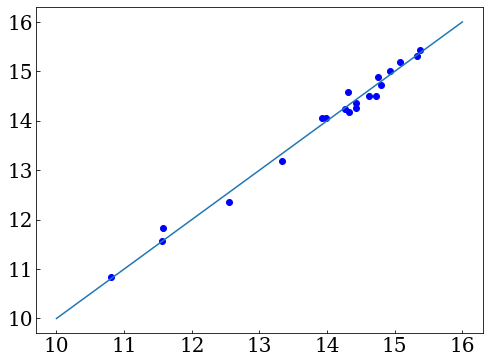

[26.64737265]
[[0.001481]]


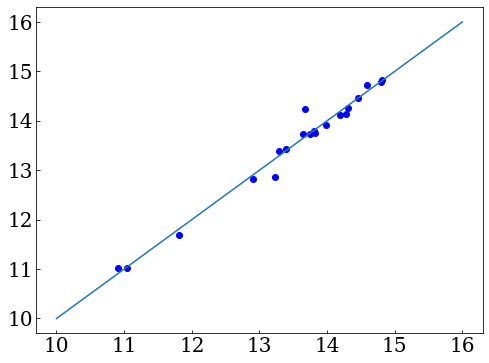

[12.89995  14.596979 14.808561 13.801082 11.035522 14.801753 10.914579
 13.637474 14.304059 13.986531 13.826398 14.460387 14.184357 13.394506
 13.232779 13.668986 11.812851 13.293402 13.751526 14.272998]


In [138]:
# calculating guess for zeropoint:
def linear(x,b):
    return x+b

# Convert the fluxes to 'magnitudes' with mx = -2.5*log_10(Flux)
mx = {}
mxerr = {}
mmx = {}
for f in filt:
    mx[f] = -2.5*np.log10(flux[f])
    mxerr[f] = 2.5/np.log(10) * (fluxerr[f]/flux[f])
    #mxerr_J0600[f] = 2.5*J0600_fluxerr[f]/J0600_flux[f]*1/np.log(10)
    tmp = []
    for s in range(N_stars):
        nonNaN = np.isnan(mx[f][:,s]) == False
        mm = np.mean(mx[f][:,s][nonNaN])
        tmp.append(mm)
    mmx[f] = np.array(tmp)    

x = np.linspace(10,16,100)
for f in filt2:
    popt, pcov = optimize.curve_fit(linear, mmx[f], gaia_mag[f])
    print (popt)
    print (pcov)

    plt.scatter(gaia_mag[f],mmx[f]+popt,c='b')
    plt.plot(x,x)
    plt.show()
print (gaia_mag[f])

In [101]:
from scipy import optimize

def mag(mx, a1, a3, a4):#, a5):#, a6):
    
    return mx + a1*X + a3*c*X + a4*(c**2) #+a5*(c**3) #+ a6*(c**4) #+ ....

#def mag(mx, a0, a1, a2, a3, a4):#, a5):#, a6):
#    
#    return mx + a0 + a1*X + a2*c + a3*c*X + a4*c**2 #+a5*c**3 #+ a6*c**4 #+ ....


fit_result = {}
fit_resulterr = {}
for f in filt2:
    tmp = []
    tmp2 = []
    for e in range(len(epoch[f])):
        nonNaN = np.isnan(mx[f][e]) == False
        
        X = airmass[f][e]
        M = mx[f][e][nonNaN]
        c = (gaia_mag['gp']-gaia_mag['rp'])[nonNaN]
        
        popt, pcov = optimize.curve_fit(mag,M, gaia_mag[f][nonNaN], p0=[27,0,0],\
                                        bounds=([0,-0.02,-0.02],[50,0.02,0.02],))
        #popt, pcov = optimize.curve_fit(mag,M, gaia_mag[f][nonNaN], p0=[27,0,0],\
        #                                bounds=([0,-10,-10],[50,10,10]))
        #popt, pcov = optimize.curve_fit(mag,M, gaia_mag[f][nonNaN], p0=[27,0,0,0,0],
        #                                bounds=([0,-10,-10,-10,-10],[50,10,10,10,10]))
        
        
        tmp.append(np.array(popt))
        tmp2.append(np.sqrt(np.diag(pcov)))
    fit_result[f] = np.array(tmp)
    fit_resulterr[f] = np.array(tmp2)


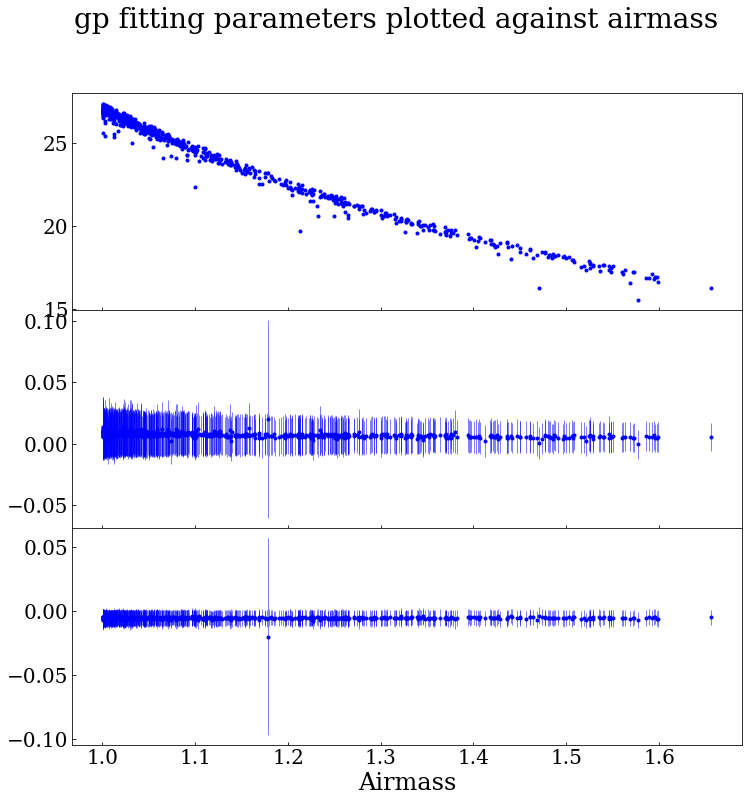

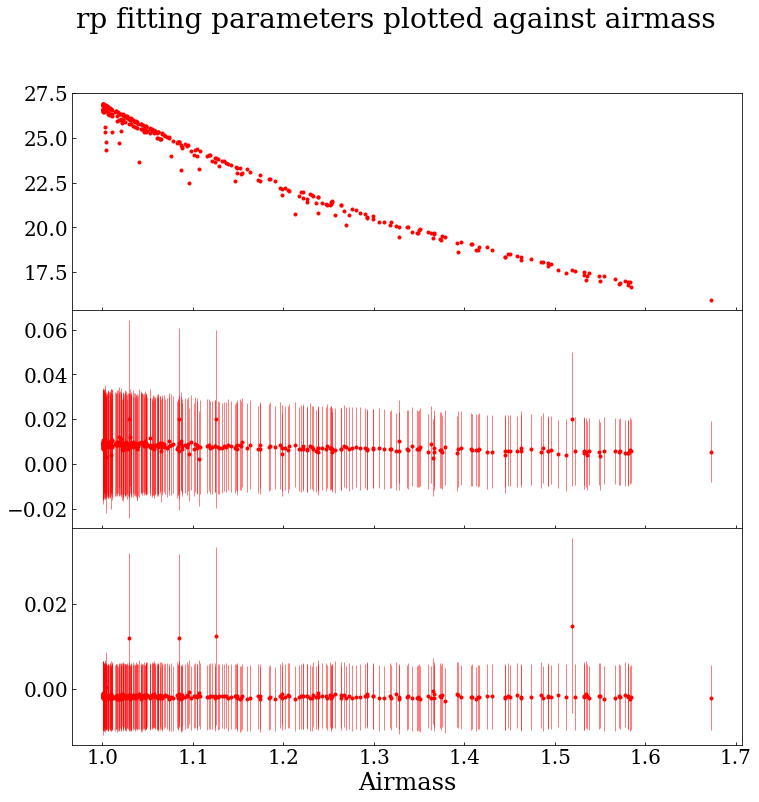

In [102]:
#tmp = ['zeropoint','airmass','colour','airmass+colour','colour^2']
tmp1 = ['a0','a1','a2','a3','a4','a5']#,'a6']
tmp2 = {'gp':'b','rp':'r'}
N_fit_params = len(fit_result['gp'][0])

#for f in filt2:
#    fig, axs = plt.subplots(N_fit_params, sharex=True, gridspec_kw={'hspace': 0})
#    fig.suptitle(f+' error of fitting parameters plotted against epoch')
#    fig.set_figheight(12)
#    fig.set_figwidth(12)
#    for i in range(N_fit_params):
#        axs[i].errorbar(epoch[f], fit_result[f][:,i],yerr=fit_resulterr[f][:,i],fmt='--.',linewidth=0.5,c=tmp2[f])
        #axs[i].set_ylim([-.02,.02])
#    axs[N_fit_params-1].set_xlabel("Epoch (MJD)")
    # Hide x labels and tick labels for all but bottom plot.
#    for ax in axs:
#        ax.label_outer()

for f in filt2:
    fig, axs = plt.subplots(N_fit_params, sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(f+' fitting parameters plotted against airmass')
    fig.set_figheight(12)
    fig.set_figwidth(12)
    for i in range(N_fit_params):
        axs[i].errorbar(airmass[f], fit_result[f][:,i],yerr=fit_resulterr[f][:,i],fmt='.',linewidth=0.5,c=tmp2[f])
#        axs[i].set_ylim([-.1,.1])
    axs[N_fit_params-1].set_xlabel("Airmass")
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()

In [103]:
for f in filt2:
    print (np.sum(np.abs(fit_result[f][:,1]) > 0.05))

0
0


In [104]:
badfitmask = {}
nr_badimg = {'gp':1,'rp':4}

for f in filt2:
    i = np.argsort(np.abs(fit_result[f][:,1]))
    tmp = []
    for e in range(len(epoch[f])):
        tmp.append(fit_result[f][e,1] not in fit_result[f][:,1][i][-nr_badimg[f]:])
    
    badfitmask[f] = np.array(tmp)
    print (np.sum(badfitmask[f]==False))

1
4


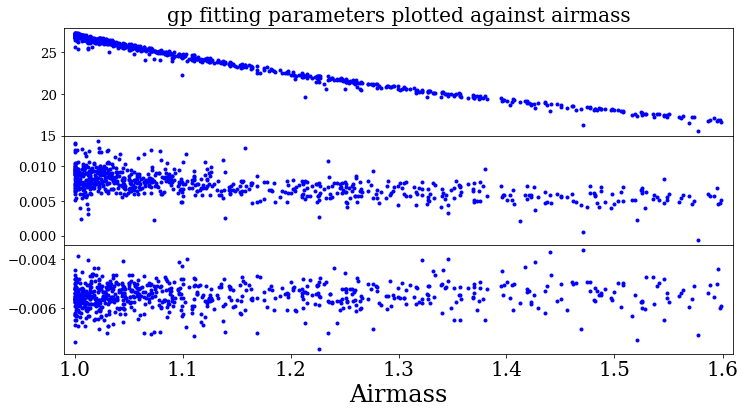

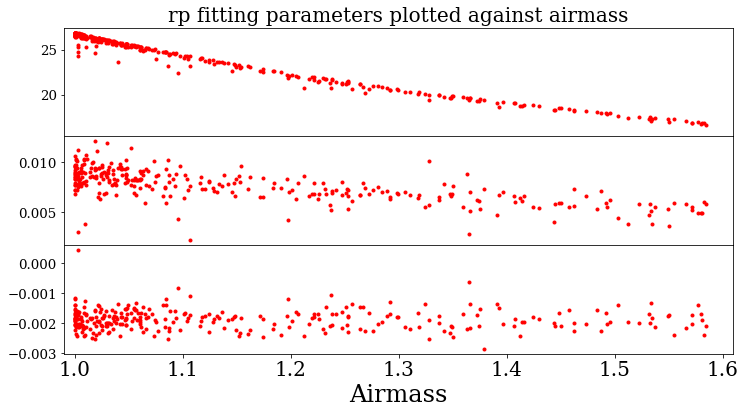

In [164]:
#tmp = ['zeropoint','airmass','colour','airmass+colour','colour^2']
tmp1 = ['a0','a1','a2','a3','a4','a5']#,'a6']
tmp2 = {'gp':'b','rp':'r'}
N_fit_params = len(fit_result['gp'][0])

for f in filt2:
    fig, axs = plt.subplots(N_fit_params, sharex=True, gridspec_kw={'hspace': 0})
    fig.set_figheight(6)
    fig.set_figwidth(12)
    for i in range(N_fit_params):
        axs[i].errorbar(airmass[f][badfitmask[f]], fit_result[f][:,i][badfitmask[f]],\
                        fmt='.',linewidth=0.5,c=tmp2[f])
#        axs[i].set_ylim([-.1,.1])
    axs[N_fit_params-1].set_xlabel("Airmass")
    axs[N_fit_params-1].set_xlim([0.99,1.61])
    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer()
    axs[0].set_title(f+' fitting parameters plotted against airmass')

In [106]:
# Calculate magnitude and mean magnitude for all fit parameters
c = (gaia_mag['gp']-gaia_mag['rp'])

magnitude = {}
magnitudeerr = {}
for f in filt2:
    tmp = []
    tmp2 = []
    for e in range(len(epoch[f])):
        X = airmass[f][e]
        m = mag(mx[f][e],*fit_result[f][e])
        tmp.append(m)
        
        merr = np.sqrt(mxerr[f][e]**2 + (X*fit_resulterr[f][e][0])**2 + (c*X*fit_resulterr[f][e][1])**2 +\
                      (c**2 * fit_resulterr[f][e][2])**2)
        tmp2.append(merr)
    magnitude[f] = np.array(tmp)
    magnitudeerr[f] = np.array(tmp2)

mmag = {}
for f in filt2:
    tmp = []
    for s in range(N_stars):
        nonNaN = np.isnan(magnitude[f][:,s]) == False
        mm = np.median(magnitude[f][:,s][nonNaN])
        tmp.append(mm)
    mmag[f] = np.array(tmp)


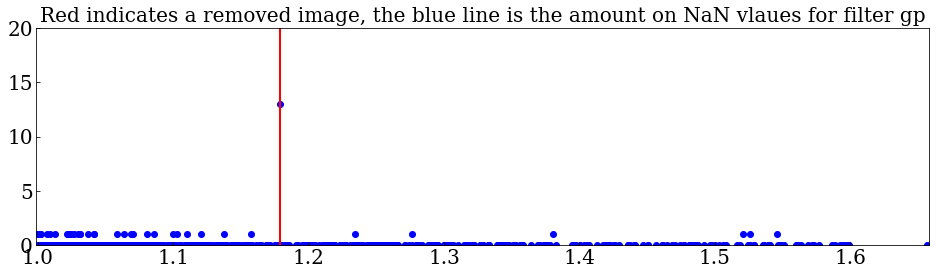

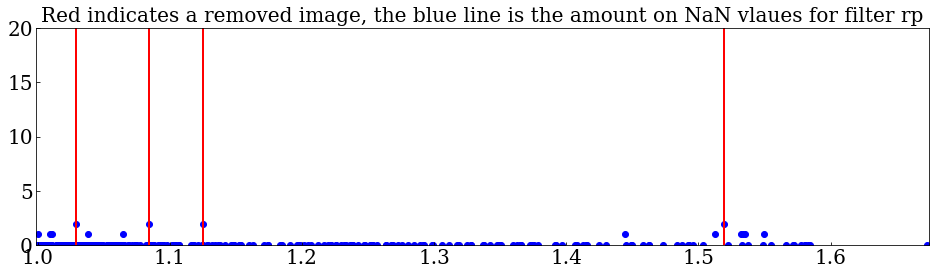

In [107]:
# Make a plot to show the correlation between NaN values and the fit doing weird stuff

for f in filt2:
    tmp = np.sum(np.isnan(magnitude[f]),axis=1)
    plt.figure(figsize=(16,4))
    for e in np.arange(len(epoch[f]))[badfitmask[f]==False]:
        plt.plot([airmass[f][e],airmass[f][e]],[0,50],linewidth=2,c='r')
    plt.scatter(airmass[f],tmp,c='b')
    plt.title("Red indicates a removed image, the blue line is the amount on NaN vlaues for filter "+f)
    plt.axis(ymin=-0.00,ymax=20,xmin=0.999,xmax=np.max(airmass[f])*1.001)
    plt.show()

In [143]:
cormag = {}
cormagerr = {}
cormmag = {}
corepoch = {}
corairmass = {}
for f in filt2:
    cormag[f] = magnitude[f][badfitmask[f]]
    cormagerr[f] = magnitudeerr[f][badfitmask[f]]
    tmp = []
    for s in range(N_stars):
        nonNaN = np.isnan(cormag[f][:,s])==False
        tmp.append(np.mean(cormag[f][:,s][nonNaN]))
    cormmag[f] = np.array(tmp)
    corepoch[f] = epoch[f][badfitmask[f]]
    corairmass[f] = airmass[f][badfitmask[f]]

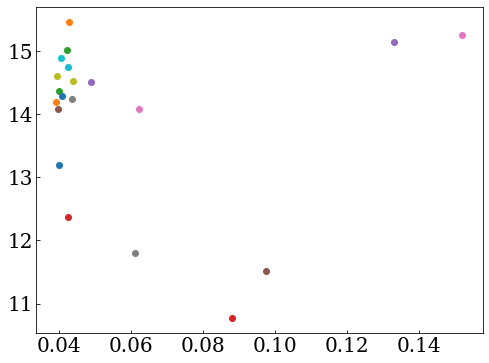

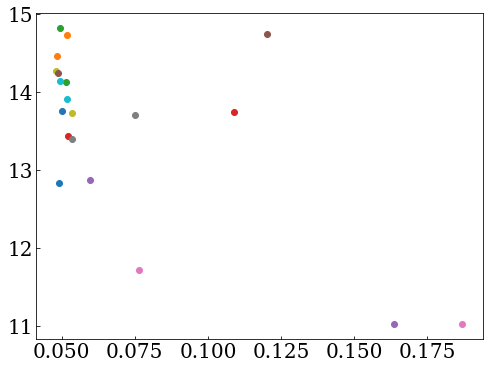

In [151]:
for f in filt2:
    for s in range(N_stars):
        nonNaN = np.isnan(cormagerr[f][:,s]) == False
        plt.scatter(np.median(cormagerr[f][:,s][nonNaN]),cormmag[f][s])
    plt.show()

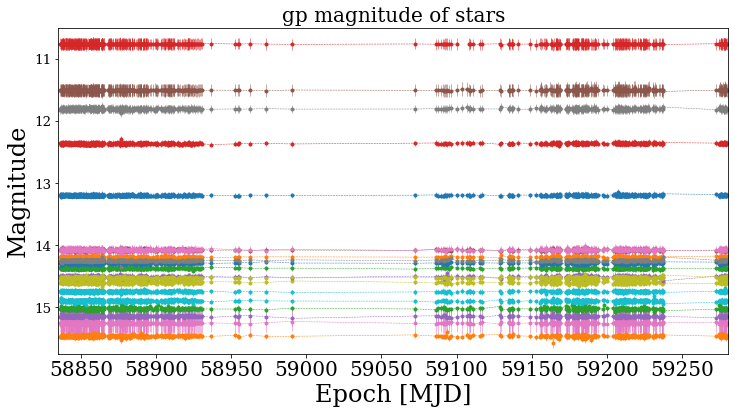

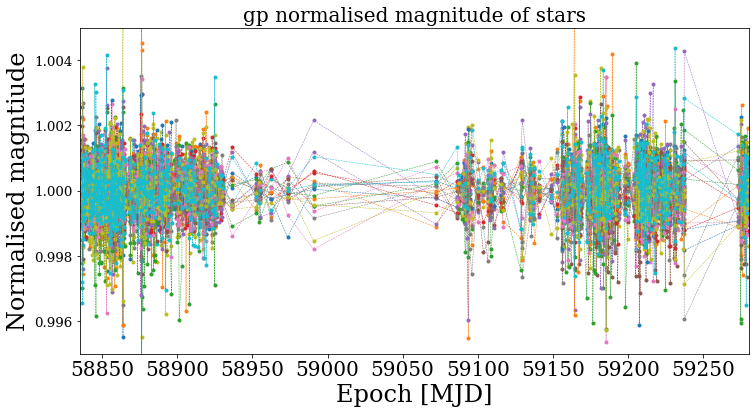

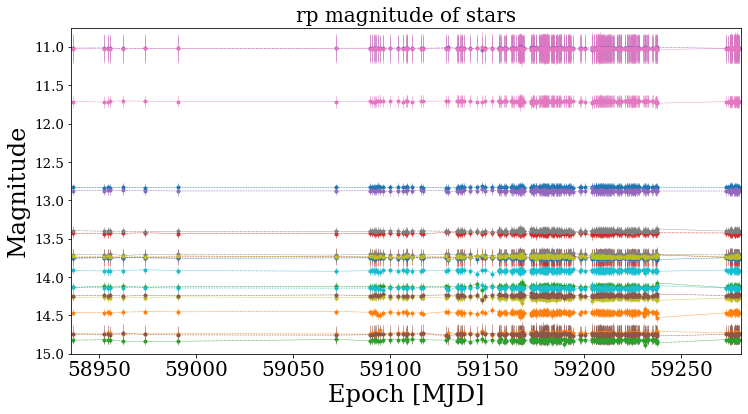

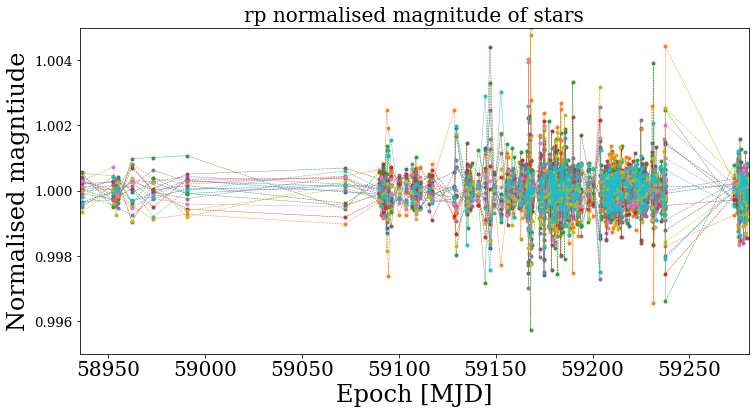

272
0
58876.2064325
(array([272]),)


In [170]:
tmp = {'gp':[15.75,10.5],'rp':[15,10.75]}

for f in filt2:
    plt.figure(figsize=(12,6))
    for s in range(N_stars):
        plt.errorbar(corepoch[f],cormag[f][:,s],yerr=cormagerr[f][:,s], fmt='--.',linewidth=0.5)#,label=s)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" magnitude of stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Magnitude")
    plt.axis(ymin=tmp[f][0], ymax=tmp[f][1],xmin=corepoch[f][0]-1,xmax=corepoch[f][-1]+1)
    plt.show()
    plt.figure(figsize=(12,6))
    for s in range(N_stars):
        plt.errorbar(corepoch[f],cormag[f][:,s]/mmag[f][s],\
                     fmt='--.', linewidth=0.5,label=s+1)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised magnitude of stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Normalised magntiude")
    plt.axis(ymin=0.995,ymax=1.005,xmin=corepoch[f][0]-1,xmax=corepoch[f][-1]+1)
    plt.savefig('../Slide_pics/Atmospheric-extinction-corrected-normalised_flux_'+f)
    plt.show()

f='gp'
nonNaN = np.isnan(cormag[f][:,17]/mmag[f][s]) == False
print (np.argmax(cormag[f][:,17]/mmag[f][s]))
print (np.sum(nonNaN == False))
print (corepoch[f][nonNaN][272])
print (np.where(corepoch[f][nonNaN][272] == corepoch[f]))

In [110]:
#f = 'gp'
#for s in range(N_stars):
#    plt.hist(magnitude[f][:,s]/mmag[f][s], bins=50,range=(0.99,1.01))
#    plt.show()

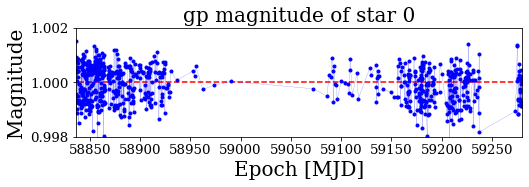

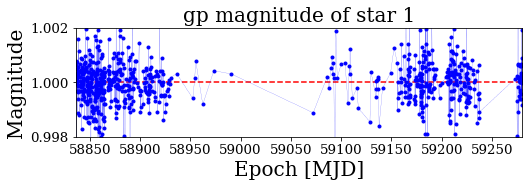

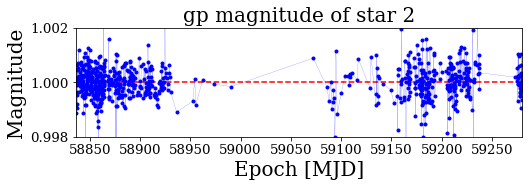

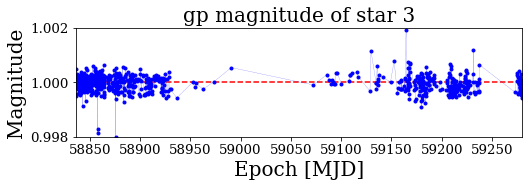

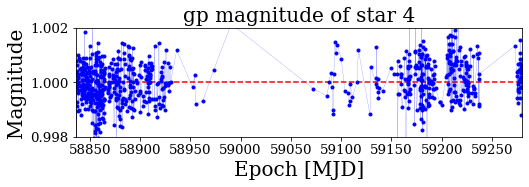

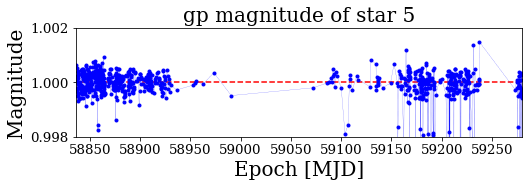

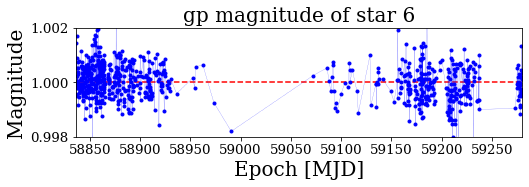

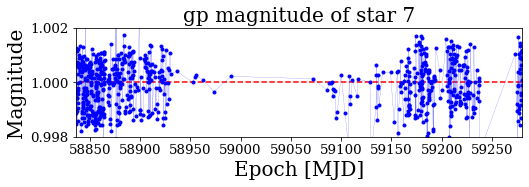

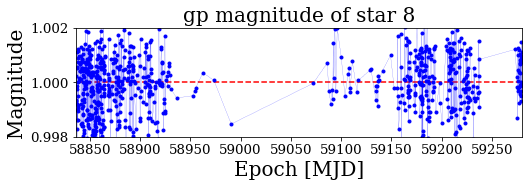

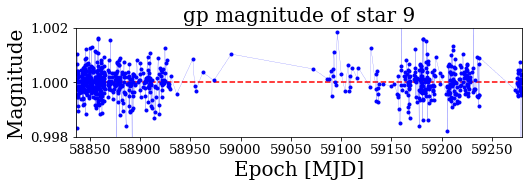

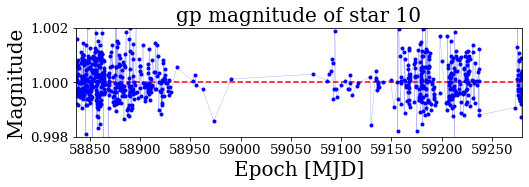

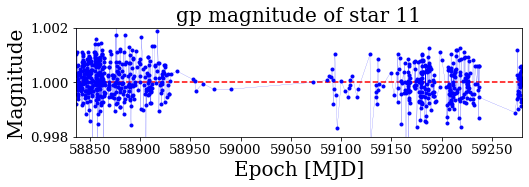

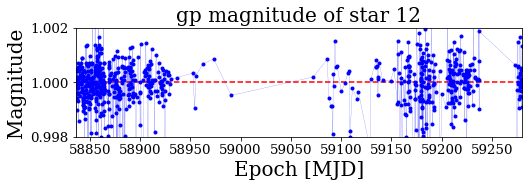

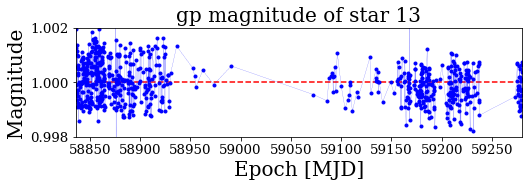

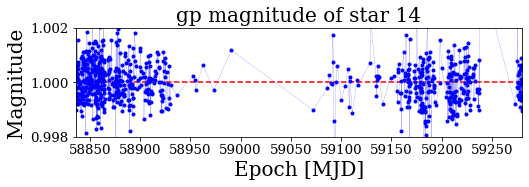

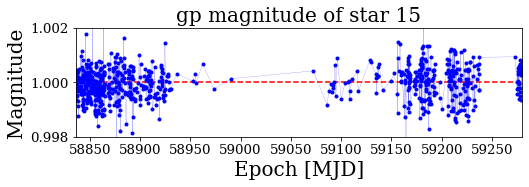

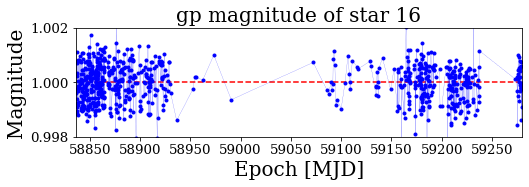

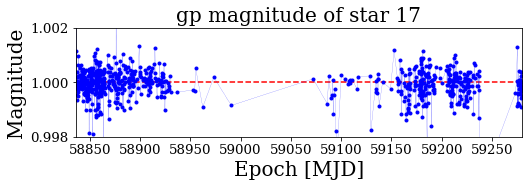

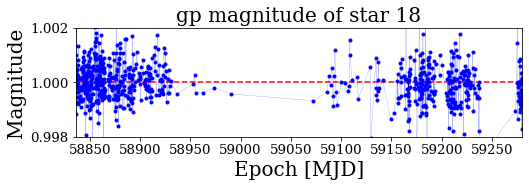

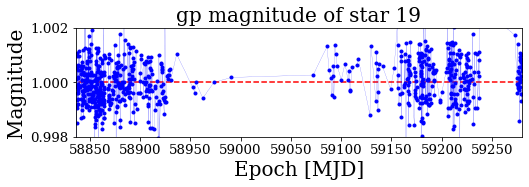

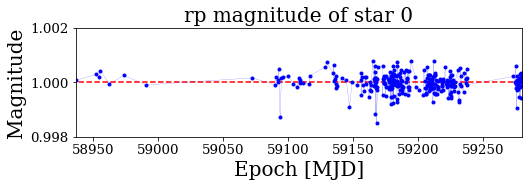

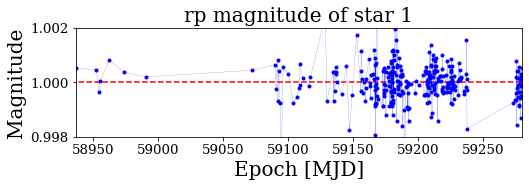

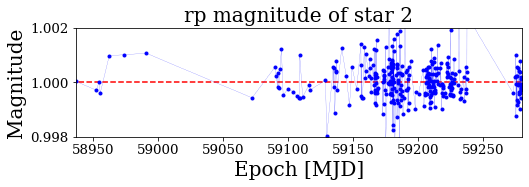

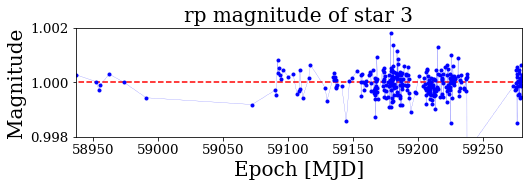

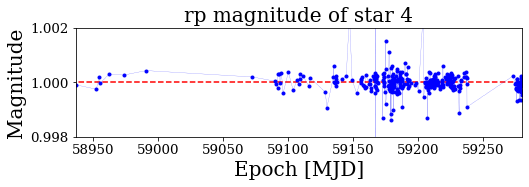

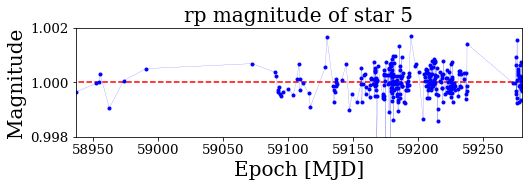

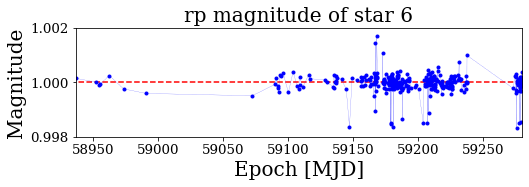

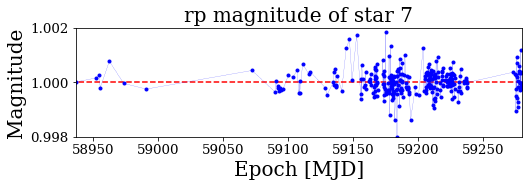

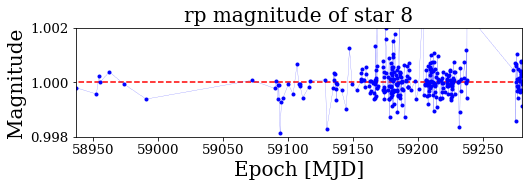

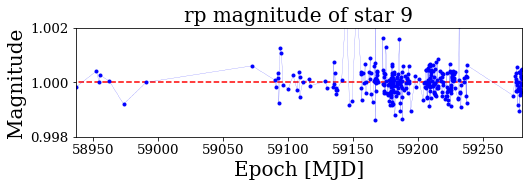

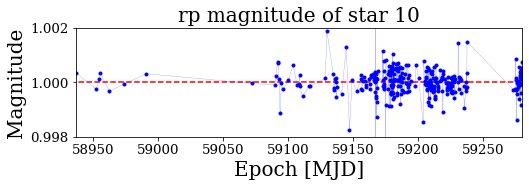

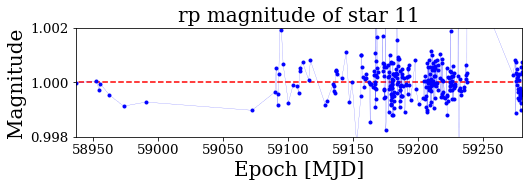

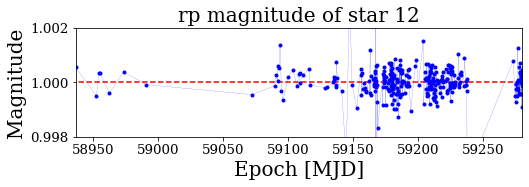

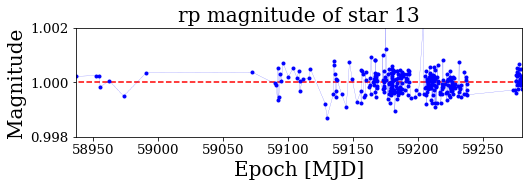

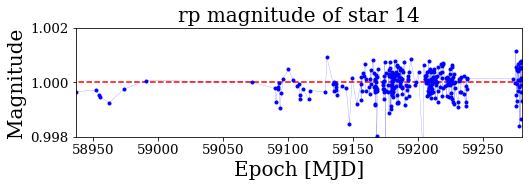

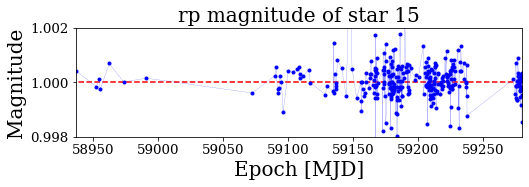

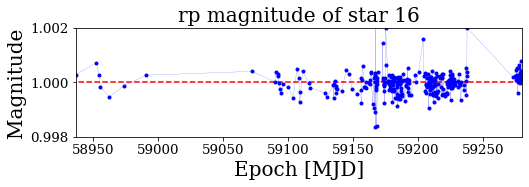

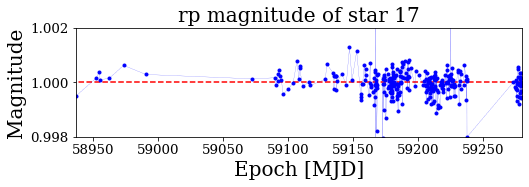

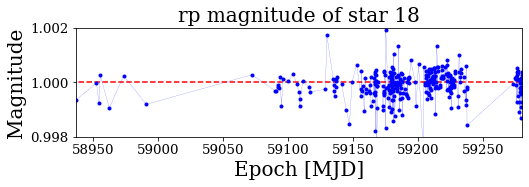

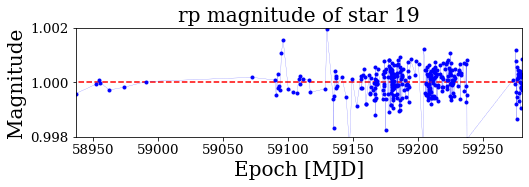

In [192]:
for f in filt2:
    for s in range(N_stars):
        plt.figure(figsize=(8,2))
        plt.plot([0,1e6],[1,1],c='r',linestyle='dashed')
        plt.errorbar(corepoch[f],cormag[f][:,s]/mmag[f][s],\
                     fmt='--.',linewidth=0.2,c='b')#,label=s)
        #plt.errorbar(airmass[f][badfitmask[f]==False],(magnitude[f][:,s]/mmag[f][s])[badfitmask[f]==False],\
        #             yerr=(magnitudeerr[f][:,s]/mmag[f][s])[badfitmask[f]==False],fmt='o',linewidth=0.5,c='r')
        #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        plt.title(f+" magnitude of star "+str(s))
        plt.xlabel("Epoch [MJD]")
        plt.ylabel("Magnitude")
        plt.xlim(xmin=np.min(epoch[f]),xmax=np.max(epoch[f]))#58930)
        plt.ylim(ymin=0.998,ymax=1.002)
        #plt.yscale('log')
        plt.show()

#for f in filt2:
#    for s in range(N_stars):
#        plt.figure(figsize=(10,4))
#        plt.plot([0,1e6],[1,1],c='r',linestyle='dashed')
#        plt.plot(epoch[f],magnitude[f][:,s]/mmag[f][s],linestyle='dashed',marker='.',linewidth=0.5)#,label=s)
#        #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
#        plt.title(f+" magnitude of star "+str(s))
#        plt.xlabel("Epoch [MJD]")
#        plt.ylabel("Magnitude")
#        plt.axis(ymin=0.95,ymax=1.05, xmax=epoch[f][-1],xmin=epoch[f][0])#59100)
        #plt.yscale('log')
#        plt.show()

In [112]:
mx_J0600 = {}
mxerr_J0600 = {}
for f in filt2:
    mx_J0600[f] = -2.5*np.log10(J0600_flux[f])
    mxerr_J0600[f] = (2.5*J0600_fluxerr[f]/J0600_flux[f])*(1/np.log(10))
#    print (mx_J0600[f])

c = J0600_gaia['phot_g_mean_mag']-J0600_gaia['phot_rp_mean_mag']
J0600_mag = {}
J0600_magerr = {}
for f in filt2:
    tmp = []
    tmp2 = []
    for e in range(len(epoch[f])):
        X = airmass[f][e]
        m = mag(mx_J0600[f][e],*fit_result[f][e])
        merr = np.sqrt(mxerr_J0600[f][e]**2 + (fit_resulterr[f][e][0])**2 + (c*fit_resulterr[f][e][1])**2 +\
                      (c**2 * fit_resulterr[f][e][2])**2)
        
        tmp.append(m)
        tmp2.append(merr)
    J0600_mag[f] = np.array(tmp)
    J0600_magerr[f] = np.array(tmp2)

J0600_mmag = {}
for f in filt2:
    nonNaN = np.isnan(J0600_mag[f]) == False
    J0600_mmag[f] = np.mean(J0600_mag[f][nonNaN])

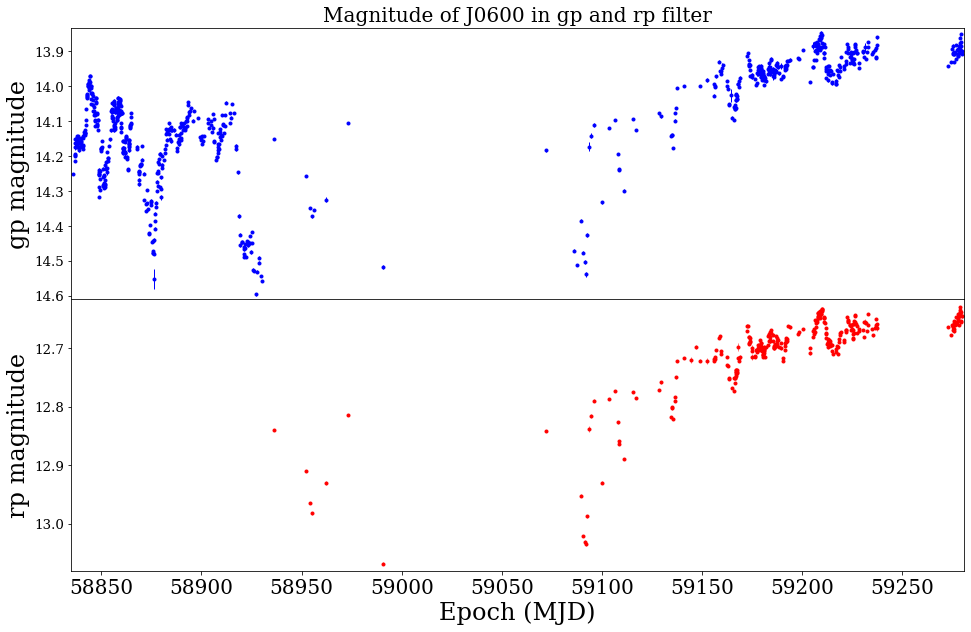

In [176]:
#for f in filt2:
#    plt.plot(epoch[f],J0600_magnitude[f], linestyle='dashed',linewidth=0.5,marker='.')
    
    #plt.axis(ymin = np.max(J0600_magnitude[f][nonNaN]), ymax=np.min(J0600_magnitude[f][nonNaN]))
#    plt.show()
mask = {}
for f in filt2:
    mask[f] = airmass[f]<1.42

tmp2 = {'gp':'b','rp':'r'}

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Magnitude of J0600 in gp and rp filter ')
fig.set_figheight(10)
fig.set_figwidth(16)
f = 'gp'
axs[0].set_title('Magnitude of J0600 in gp and rp filter')
axs[0].errorbar(epoch[f], J0600_mag[f], yerr=mxerr_J0600[f], fmt='.',linewidth=1,c=tmp2[f])
#axs[0].plot([0,1e6],[J0600_gaia['phot_g_mean_mag'],J0600_gaia['phot_g_mean_mag']],linestyle='dashed',c='black')
axs[0].set_ylim([1.001*np.max(J0600_mag[f]),0.999*np.min(J0600_mag[f])])
axs[0].set_ylabel("gp magnitude")
axs[1].set_xlim([epoch[f][0]-1,epoch[f][-1]+1])
f = 'rp'
axs[1].errorbar(epoch[f], J0600_mag[f], yerr=mxerr_J0600[f], fmt='.',linewidth=0.5,c=tmp2[f])
#axs[1].plot([0,1e6],[J0600_gaia['phot_rp_mean_mag'],J0600_gaia['phot_rp_mean_mag']],linestyle='dashed',c='black')
axs[1].set_ylim([1.001*np.max(J0600_mag[f]),0.999*np.min(J0600_mag[f])])
axs[1].set_ylabel("rp magnitude")
axs[1].set_xlabel("Epoch (MJD)")

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

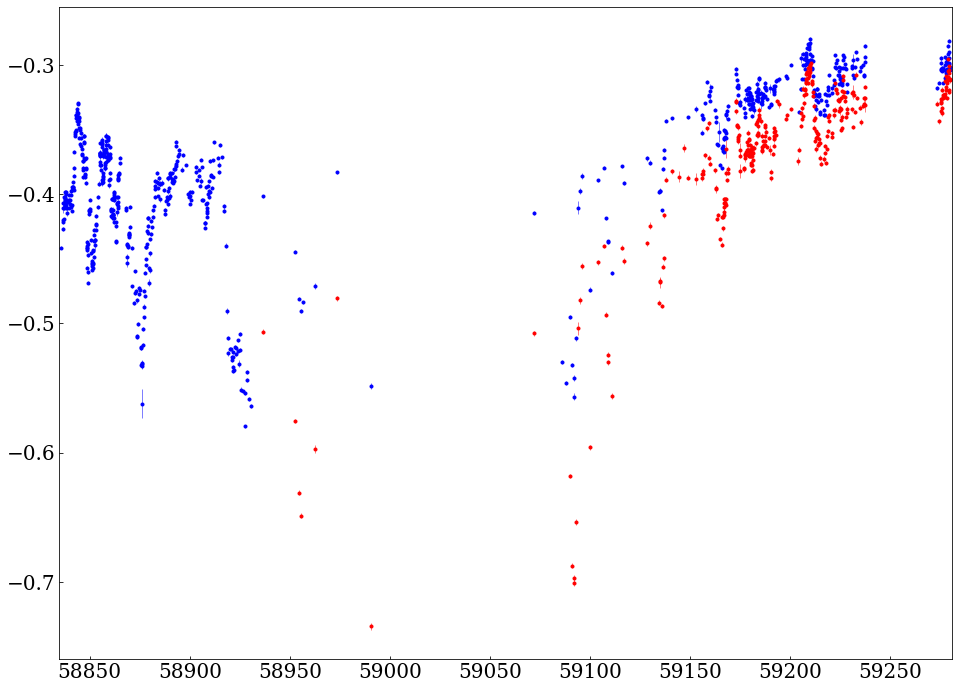

In [114]:
# J0600_gaia['phot_g_mean_mag']-J0600_gaia['phot_rp_mean_mag']
factor = 2.5 #ESTIMATE OF WRONG FACTOR SOMEWHERE
plt.figure(figsize=(16,12))
f = 'gp'
plt.errorbar(epoch[f], (J0600_gaia['phot_g_mean_mag'] - J0600_mag[f])/factor, yerr=mxerr_J0600[f]/factor, fmt='.',linewidth=0.5,c=tmp2[f])
plt.xlim([epoch[f][0]-1,epoch[f][-1]+1])
f = 'rp'
plt.errorbar(epoch[f], J0600_gaia['phot_rp_mean_mag'] - J0600_mag[f], yerr=mxerr_J0600[f], fmt='.',linewidth=0.5,c=tmp2[f])
#plt.ylim([1.001*np.max(J0600_mag[f]),0.999*np.min(J0600_mag[f])])
plt.show()

In [212]:
f = 'gp'
s = 3
print (np.where(epoch[f]>58932))
print (epoch[f][427])
N = 428

(array([428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
       441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453,
       454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,
       467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
       480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492,
       493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505,
       506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
       519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531,
       532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544,
       545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557,
       558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583,
       584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596,
       597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 6

In [224]:
sick = (cormag[f][:N,s]/mmag[f][s])

leuk_nr = {'gp':5}


i = np.argsort(np.abs(sick-1))
tmp = []
for e in range(N):
    tmp.append(sick[e] not in sick[i][-leuk_nr[f]:])

leuk = np.array(tmp)
print (np.sum(leuk==False))

5


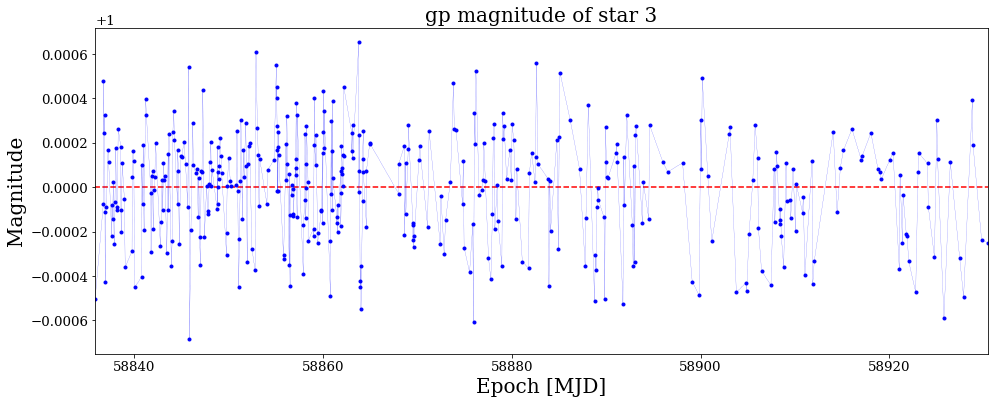

In [229]:
# Looking for millimagnitude variations:
plt.figure(figsize=(16,6))
plt.plot([0,1e6],[1,1],c='r',linestyle='dashed')
plt.errorbar(corepoch[f][:N][leuk],sick[leuk], fmt='--.',linewidth=0.2,c='b')
plt.title(f+" magnitude of star "+str(s))
plt.xlabel("Epoch [MJD]")
plt.ylabel("Magnitude")
#plt.xlim(58850,58860)
plt.xlim(np.min(epoch[f]),epoch[f][N-1])#,58932)
#plt.ylim(ymin=0.998,ymax=1.002)
#plt.yscale('log')
plt.show()

In [243]:
def sine(x, x0, T):
    return 5e-4*np.sin((x+x0)*2*np.pi/T) + 1

popt, pcov = optimize.curve_fit(sine, corepoch[f][:N][leuk],sick[leuk],p0=[0,0.2])
print (popt)

[4.90263153 0.20001683]


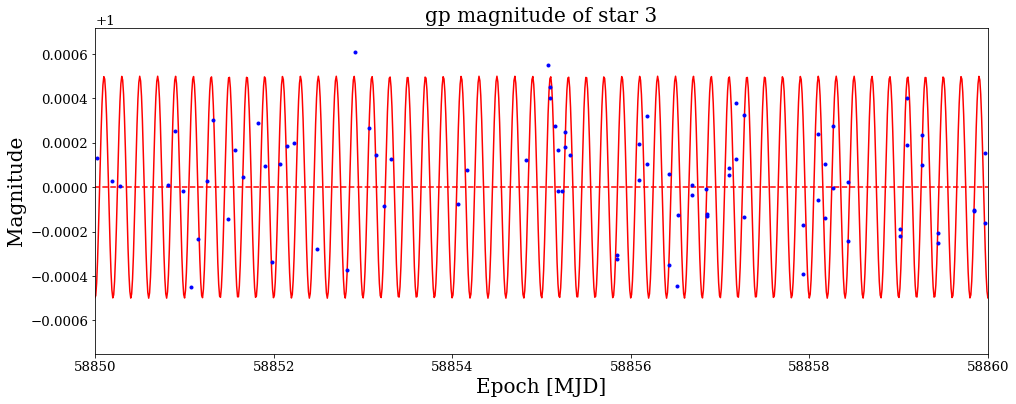

In [245]:
plt.figure(figsize=(16,6))
plt.plot([0,1e6],[1,1],c='r',linestyle='dashed')
x = np.linspace(epoch[f][0],epoch[f][N],10000)
plt.plot(x,sine(x,*popt),c='r')
plt.errorbar(corepoch[f][:N][leuk],sick[leuk], fmt='.',linewidth=0.2,c='b')
plt.title(f+" magnitude of star "+str(s))
plt.xlabel("Epoch [MJD]")
plt.ylabel("Magnitude")
plt.xlim(58850,58860)
#plt.xlim(np.min(epoch[f]),epoch[f][N-1])#,58932)
#plt.ylim(ymin=0.998,ymax=1.002)
#plt.yscale('log')
plt.show()

In [28]:
# Finding the distance between chosen stars to see if two stars are extracting the same photometry

#for f in filt:
#    ra_matrix = np.array(list(star_coords[f][:,0])*N_stars).reshape(N_stars,N_stars)
#    dec_matrix = np.array(list(star_coords[f][:,1])*N_stars).reshape(N_stars,N_stars)
#    d = (ra_matrix.transpose()-ra_matrix)**2 + (dec_matrix.transpose()-dec_matrix)**2
#    plt.figure(figsize=(12,8))
#    plt.plot(d)
#    plt.axis(ymin=-0.001,ymax=0.01)
#    plt.grid()
#    plt.show()